# Using the Modo API

In [11]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt

In [46]:
start_date = "2024-11-05T02:22:22"
end_date = "2024-11-13T08:22:22"
limit = "1000"

url = "https://api.modoenergy.com/pub/v1/gb/elexon/system/fuelhh?publish_date_from=" + start_date + "&publish_date_to=" + end_date + "&limit=" + limit
# this endpoint gives the average generation of each fuel type in the UK for each half hour period in MW
headers = {
    "accept": "application/json",
    "X-Token": "6154030e85b4b167e3e3e89871e6e856ebe1c79963b60c3363b41cc8655c"
}

response = requests.get(url, headers=headers)

# print(response.text)

In [47]:
# convert the response to pandas dataframe

data = json.loads(response.text)

df = pd.DataFrame(data['results'])


# convert startTime to datetime
df['startTime'] = pd.to_datetime(df['startTime'])

print(df.head())


  dataset                publishTime                 startTime settlementDate  \
0  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   
1  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   
2  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   
3  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   
4  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   

   settlementPeriod fuelType  generation  
0                16       PS         680  
1                16  NUCLEAR        4797  
2                16     WIND        4036  
3                16  INTIFA2         276  
4                16    INTFR         582  


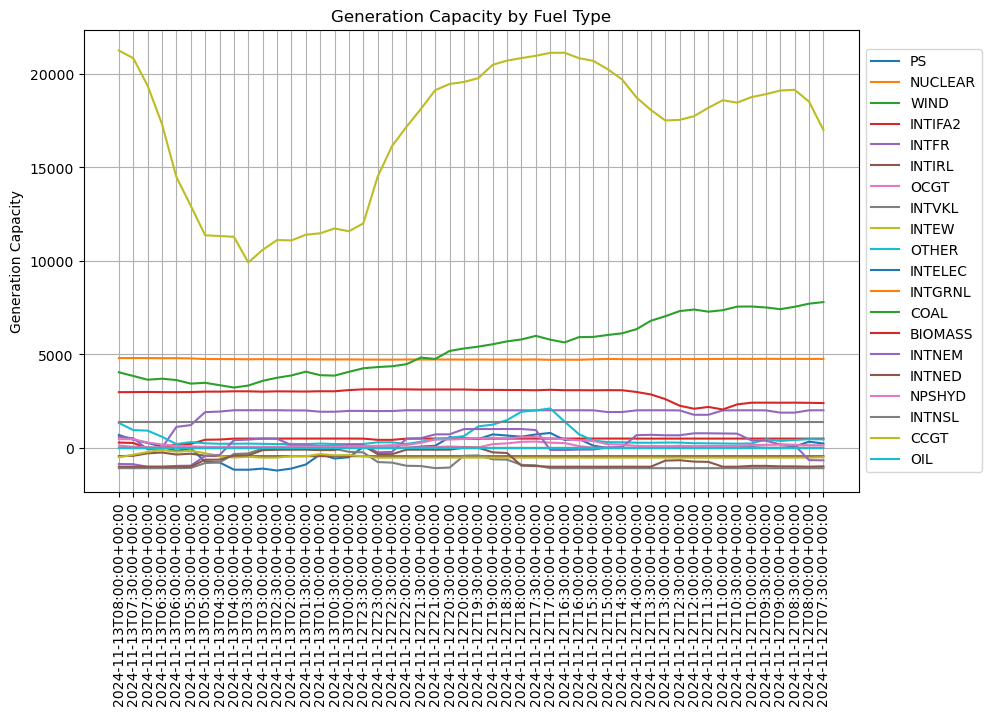

In [48]:
# plot a breakfdown of the fuel types generation capacity over the time period

# for each day
# for each fuel type plot a different color on the graph
# x-axis is the time
# y-axis is the generation capacity

# plot the graph
plt.figure(figsize=(10, 6))
for fuel_type in df['fuelType'].unique():
    fuel_df = df[df['fuelType'] == fuel_type]
    plt.plot(fuel_df['publishTime'], fuel_df['generation'], label=fuel_type)

# only label the x-axis every 100th value
plt.ylabel('Generation Capacity')
plt.title('Generation Capacity by Fuel Type')

# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# rotate the x-axis labels
plt.xticks(rotation=90)
plt.grid()

plt.show()
